In [98]:
# xoá các cột ko cần thiết cho phân tích nhiệt độ
import pandas as pd

df = pd.read_csv('data_northern_vietnam.csv')
#inplace= xoá trực tiếp ko tạo bản copy
df.drop(["STATION","LATITUDE","LONGITUDE","ELEVATION","PRCP",
"PRCP_ATTRIBUTES","TAVG_ATTRIBUTES","TMAX_ATTRIBUTES","TMIN_ATTRIBUTES"],axis=1, inplace=True)
df.to_csv('temperature.csv',index= False)

In [99]:
# đổi tên thành viết hoa chữ đầu cho các cột
df.columns = df.columns.str.title()
df.to_csv('temperature.csv',index=False)

In [100]:
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv('temperature.csv')

# Hàm tính giá trị còn thiếu nếu có 2 giá trị đã biết
def fill_missing_values(row):
    if pd.isna(row['Tmax']):
        row['Tmax'] = 2 * row['Tavg'] - row['Tmin']
    elif pd.isna(row['Tmin']):
        row['Tmin'] = 2 * row['Tavg'] - row['Tmax']
    elif pd.isna(row['Tavg']):
        row['Tavg'] = (row['Tmin'] + row['Tmax']) / 2
    return row

# Chỉ giữ lại các hàng có ít nhất 2 giá trị không phải NaN
df = df.dropna(thresh=2, subset=['Tmax', 'Tmin', 'Tavg'])

# Áp dụng hàm để tính giá trị còn thiếu
df = df.apply(fill_missing_values, axis=1)

# Lưu lại dữ liệu sau khi xử lý
df.to_csv('temperature.csv', index=False)


In [102]:
# kiểm tra xem Tmax,tmin,tavg có bất hợp lý hay ko
import pandas as pd
df = pd.read_csv('temperature.csv')
invalid_rows = df[~((df['Tmin'] <= df['Tavg']) & (df['Tavg'] <= df['Tmax']))]
print(invalid_rows)


Empty DataFrame
Columns: [Name, Date, Tavg, Tmax, Tmin]
Index: []


In [103]:
df['Name'].unique() # xem có những khu vực quan sát nào

array(['CAO BANG, VM', 'SON LA, VM', 'LANG SON, VM', 'THANH HOA, VM',
       'NOIBAI INTERNATIONAL, VM', 'HA DONG, VM'], dtype=object)

In [104]:
# kiểm tra xem có bản ghi nào trùng lặp ko
df[df.duplicated()]

,Name,Date,Tavg,Tmax,Tmin


Text(0, 0.5, 'Tavg')

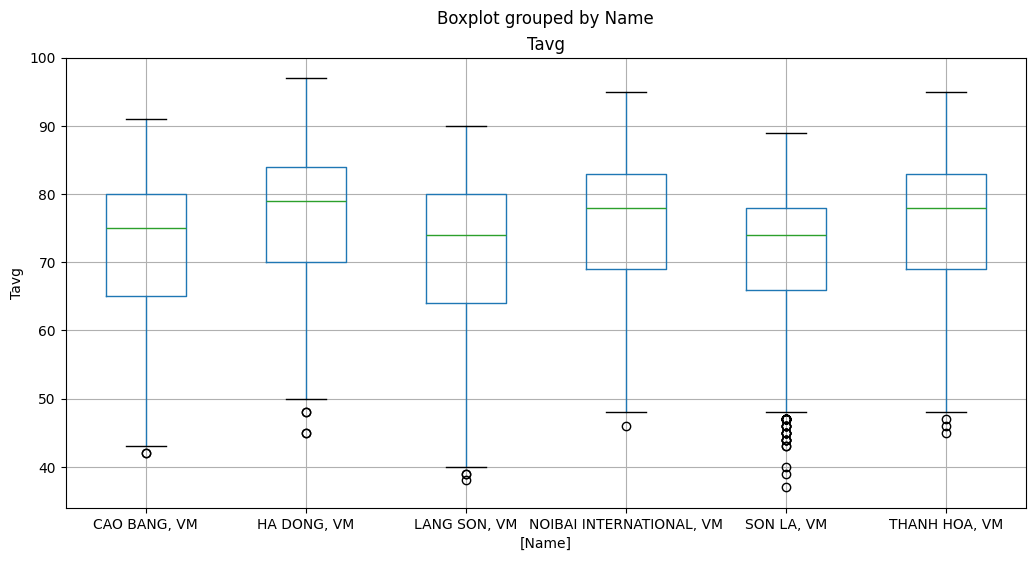

In [105]:
# kiểm tra phạm vi của Tavg
ax = df[['Tavg','Name']].boxplot(by= 'Name',figsize=(12,6))
ax.set_ylabel('Tavg')

In [106]:
import pandas as pd

# Đọc dữ liệu từ file
df = pd.read_csv('temperature.csv')

# Tính toán Q1, Q3 và IQR cho từng tỉnh
def isoutlier_column(df, column):
    df['IsOutlier'] = False  # Khởi tạo cột IsOutlier mặc định là False
    for name, group in df.groupby('Name'):
        q1 = group[column].quantile(0.25)
        q3 = group[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Lọc các giá trị outlier
        df.loc[(df['Name'] == name) & ((df[column] < lower_bound) | (df[column] > upper_bound)), 'IsOutlier'] = True
    return df

# Lấy các giá trị outlier cho từng tỉnh
df = isoutlier_column(df,'Tavg')
df.to_csv('temperature.csv', index=False)
df



,Name,Date,Tavg,Tmax,Tmin,IsOutlier
0,"CAO BANG, VM",1995-01-01,54,57.0,27.0,False
1,"CAO BANG, VM",1995-01-02,51,53.0,49.0,False
2,"CAO BANG, VM",1995-01-03,49,51.0,47.0,False
3,"CAO BANG, VM",1995-01-04,51,61.0,41.0,False
4,"CAO BANG, VM",1995-01-05,52,67.0,37.0,False
...,...,...,...,...,...,...
47625,"HA DONG, VM",2024-10-29,75,78.0,72.0,False
47626,"HA DONG, VM",2024-10-30,79,88.0,70.0,False
47627,"HA DONG, VM",2024-10-31,80,89.0,71.0,False
47628,"HA DONG, VM",2024-11-02,77,86.0,68.0,False


In [107]:
# chuyển đổi các giá trị độ F thành độ C và làm tròn
df = pd.read_csv('temperature.csv')

df['Tmax'] = round((df['Tmax']-32)/1.8, 1)
df['Tmin'] = round((df['Tmin']-32)/1.8, 1)
df['Tavg'] = round((df['Tavg']-32)/1.8, 1)

df.to_csv('temperature.csv',index= False)

In [108]:
import pandas as pd
# temperature theo năm không lấy 2024 do chưa hết năm
df = pd.read_csv('temperature.csv')

df['Year'] = pd.to_datetime(df['Date']).dt.year
# chuyển a từ series thành dataframe
a = df[df['IsOutlier']==False].groupby('Year')['Tavg'].mean().reset_index().round(1)
a = a.iloc[:-1]
a.to_csv('temperature_year.csv',index= False)

In [109]:
# temperature changes qua từng năm
import pandas as pd
import numpy as np
df = pd.read_csv('temperature_year.csv')
# tính sự thay đổi nhiệt giữa các năm
df['Temp_Change'] = df['Tavg'].diff().round(1)
# dùng loc do nó truy xuất theo label,iloc truy xuất theo chỉ số vị trí
df.loc[0,'Temp_Change'] = np.nan 
df.to_csv('temperature_year.csv',index=False)


In [110]:
# calculate nhiệt độ max, min để suy ra biên độ nhiệt theo năm
import pandas as pd

df = pd.read_csv('temperature.csv')

df['Year'] = pd.to_datetime(df['Date']).dt.year

# Tính nhiệt độ lớn nhất và nhỏ nhất theo từng năm
temp_max = df[df['Year']!=2024].groupby('Year')['Tmax'].max().reset_index(name= 'Tmax')
temp_min = df[df['Year']!=2024].groupby('Year')['Tmin'].min().reset_index(name= 'Tmin')
# Tính biên độ dao động nhiệt theo năm
df1 = pd.read_csv('temperature_year.csv')
df1 = df1.merge(temp_max, on='Year', how='left')
df1 = df1.merge(temp_min, on='Year', how='left')
df1['Temp_Range'] = (df1['Tmax']-df1['Tmin']).round(1)
df1.to_csv('temperature_year.csv',index=False)
df1

,Year,Tavg,Temp_Change,Tmax,Tmin,Temp_Range
0,1995,22.8,NaN,39.4,-3.3,42.7
1,1996,22.4,-0.4,45.0,0.6,44.4
2,1997,23.0,0.6,39.4,3.3,36.1
3,1998,23.4,0.4,39.4,3.3,36.1
4,1999,22.9,-0.5,40.0,-3.9,43.9
5,2000,22.5,-0.4,39.4,2.2,37.2
6,2001,22.5,0.0,38.3,-0.6,38.9
7,2002,22.7,0.2,38.3,2.2,36.1
8,2003,23.2,0.5,40.0,0.0,40.0
9,2004,22.3,-0.9,38.9,0.6,38.3


In [132]:
# xác định tần suất xuất hiện nhiệt cực đoan()
import pandas as pd
df = pd.read_csv('temperature.csv')
df['Year'] = pd.to_datetime(df['Date']).dt.year
# tạo cột tần suất
df_hot = isoutlier_column(df,'Tmax')
a = df_hot[df_hot['IsOutlier']==True].groupby('Year').size().reset_index(name= 'frequency_hot')
df1 = pd.read_csv('temperature_year.csv')
# on : nối dựa trên năm, how = 'left' nếu ko có giá trị thoả mãn sẽ gán NaN
df1 = df1.merge(a, on= 'Year', how= 'left')
# Kiểm tra giá trị NaN và thay thế nếu cần
df1['frequency_hot'] = df1['frequency_hot'].fillna(0).astype(int)
df_cold = isoutlier_column(df, 'Tmin')
b = df_cold[df_cold['IsOutlier'] == True].groupby('Year').size().reset_index(name='frequency_cold')
df1 = df1.merge(b, on= 'Year', how= 'left')
df1['frequency_cold'] = df1['frequency_cold'].fillna(0).astype(int)
df1.to_csv('temperature_year.csv',index= False)
df_hot[df_hot['IsOutlier']==True]

,Name,Date,Tavg,Tmax,Tmin,IsOutlier,Year
0,"CAO BANG, VM",1995-01-01,12.2,13.9,-2.8,True,1995
1317,"CAO BANG, VM",1999-01-04,11.7,27.2,-3.9,True,1999
1661,"CAO BANG, VM",1999-12-24,8.3,20.6,0.0,True,1999
4143,"CAO BANG, VM",2006-12-19,10.6,22.2,-1.1,True,2006
4146,"CAO BANG, VM",2006-12-22,10.0,23.3,-3.3,True,2006
4479,"CAO BANG, VM",2007-11-28,12.2,24.4,0.0,True,2007
4480,"CAO BANG, VM",2007-11-29,11.1,23.3,-1.1,True,2007
4868,"CAO BANG, VM",2009-01-10,9.4,20.0,-1.1,True,2009
5903,"CAO BANG, VM",2011-12-25,9.4,19.4,-0.6,True,2011
6617,"CAO BANG, VM",2013-12-18,9.4,18.9,0.0,True,2013


In [133]:
df_cold[df_cold['IsOutlier']==True]

,Name,Date,Tavg,Tmax,Tmin,IsOutlier,Year
0,"CAO BANG, VM",1995-01-01,12.2,13.9,-2.8,True,1995
1317,"CAO BANG, VM",1999-01-04,11.7,27.2,-3.9,True,1999
1661,"CAO BANG, VM",1999-12-24,8.3,20.6,0.0,True,1999
4143,"CAO BANG, VM",2006-12-19,10.6,22.2,-1.1,True,2006
4146,"CAO BANG, VM",2006-12-22,10.0,23.3,-3.3,True,2006
4479,"CAO BANG, VM",2007-11-28,12.2,24.4,0.0,True,2007
4480,"CAO BANG, VM",2007-11-29,11.1,23.3,-1.1,True,2007
4868,"CAO BANG, VM",2009-01-10,9.4,20.0,-1.1,True,2009
5903,"CAO BANG, VM",2011-12-25,9.4,19.4,-0.6,True,2011
6617,"CAO BANG, VM",2013-12-18,9.4,18.9,0.0,True,2013


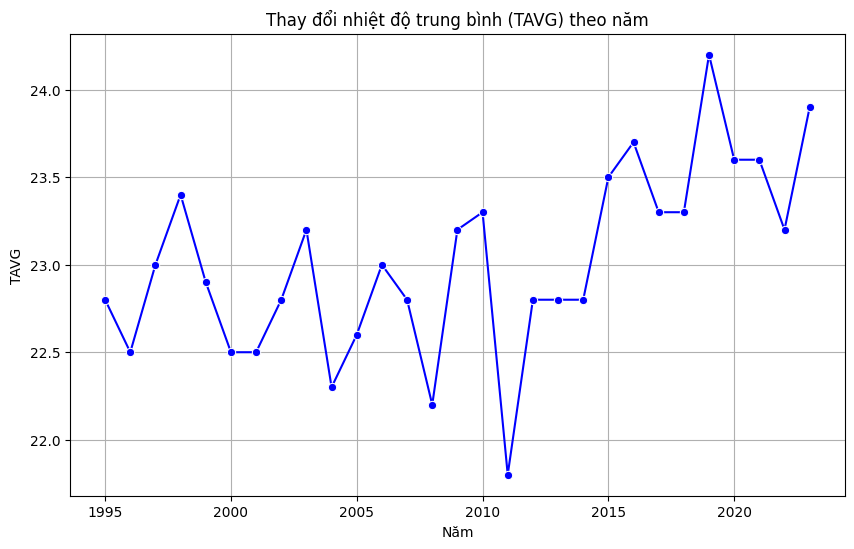

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file CSV
df = pd.read_csv('temperature_year.csv')

# Biểu đồ TAVG theo năm
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Tavg', marker='o', color='blue')
plt.title('Thay đổi nhiệt độ trung bình (TAVG) theo năm')
plt.xlabel('Năm')
plt.ylabel('TAVG')
plt.grid(True)
plt.show()


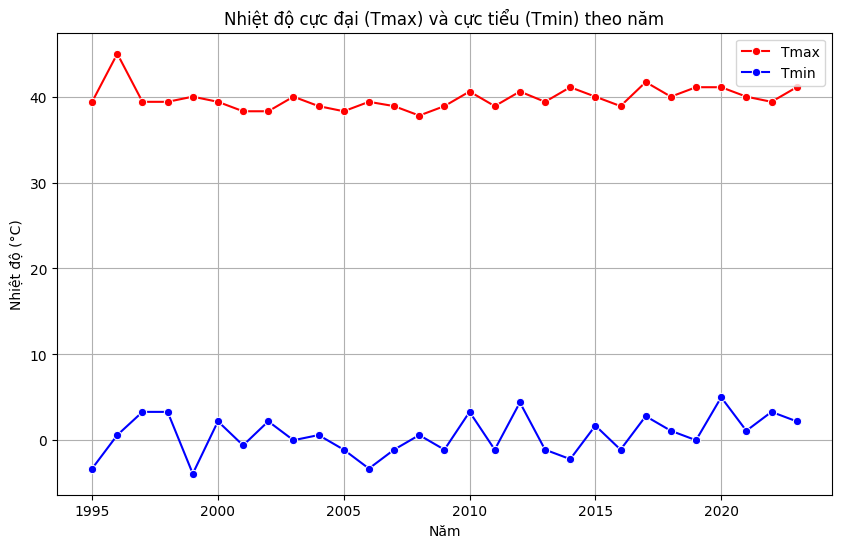

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Tmax', marker='o', color='red', label='Tmax')
sns.lineplot(data=df, x='Year', y='Tmin', marker='o', color='blue', label='Tmin')
plt.title('Nhiệt độ cực đại (Tmax) và cực tiểu (Tmin) theo năm')
plt.xlabel('Năm')
plt.ylabel('Nhiệt độ (°C)')
plt.legend()
plt.grid(True)
plt.show()


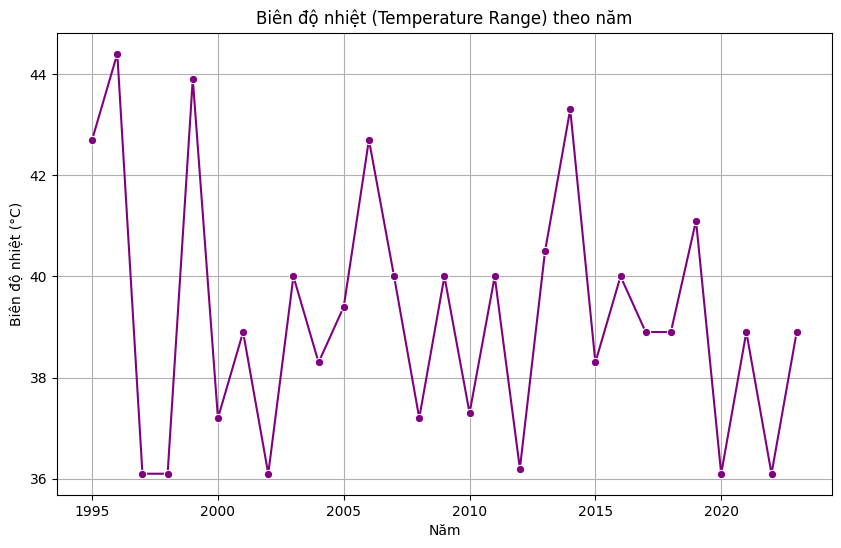

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='temperature_range', marker='o', color='purple')
plt.title('Biên độ nhiệt (Temperature Range) theo năm')
plt.xlabel('Năm')
plt.ylabel('Biên độ nhiệt (°C)')
plt.grid(True)
plt.show()


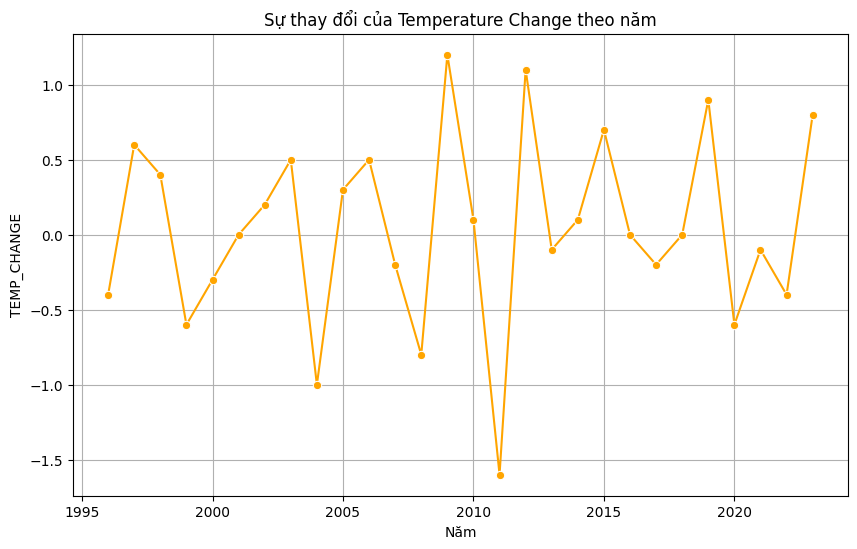

In [21]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Temp_Change', marker='o', color='orange')
plt.title('Sự thay đổi của Temperature Change theo năm')
plt.xlabel('Năm')
plt.ylabel('TEMP_CHANGE')
plt.grid(True)
plt.show()


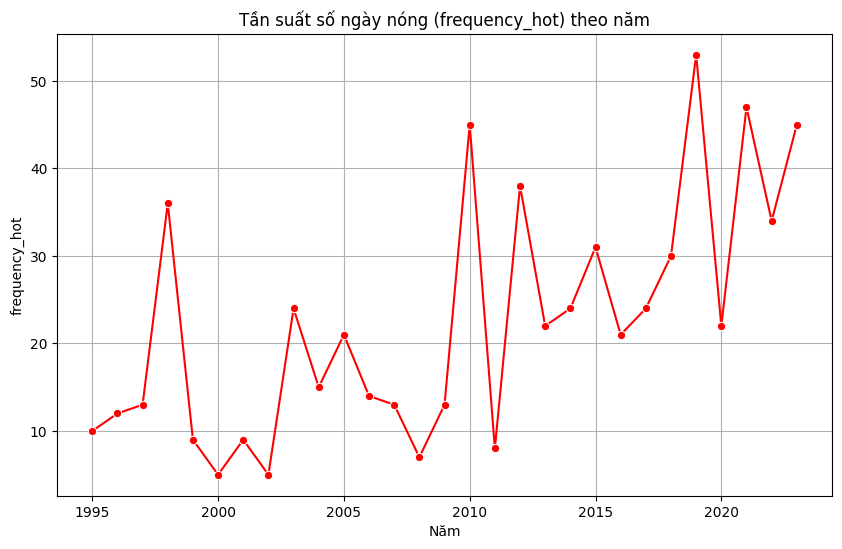

In [22]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='frequency_hot', marker='o', color='red')
plt.title('Tần suất số ngày nóng (frequency_hot) theo năm')
plt.xlabel('Năm')
plt.ylabel('frequency_hot')
plt.grid(True)
plt.show()


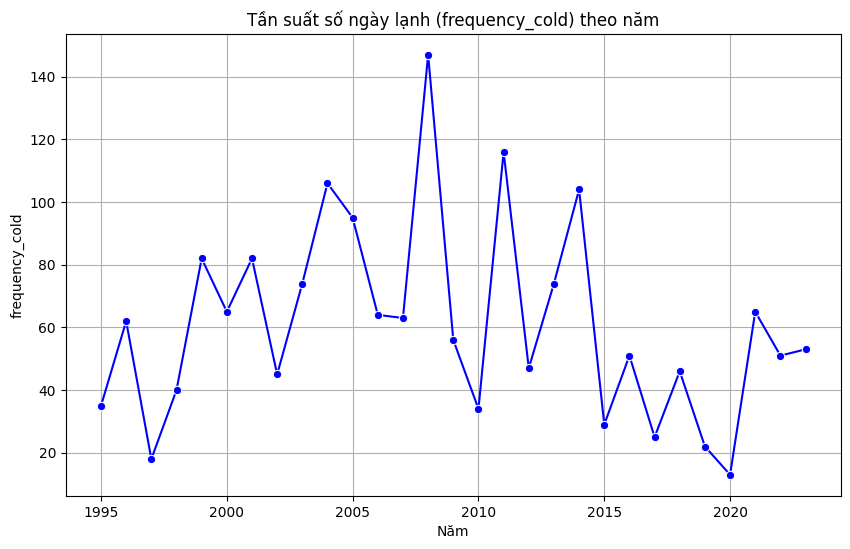

In [23]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='frequency_cold', marker='o', color='blue')
plt.title('Tần suất số ngày lạnh (frequency_cold) theo năm')
plt.xlabel('Năm')
plt.ylabel('frequency_cold')
plt.grid(True)
plt.show()


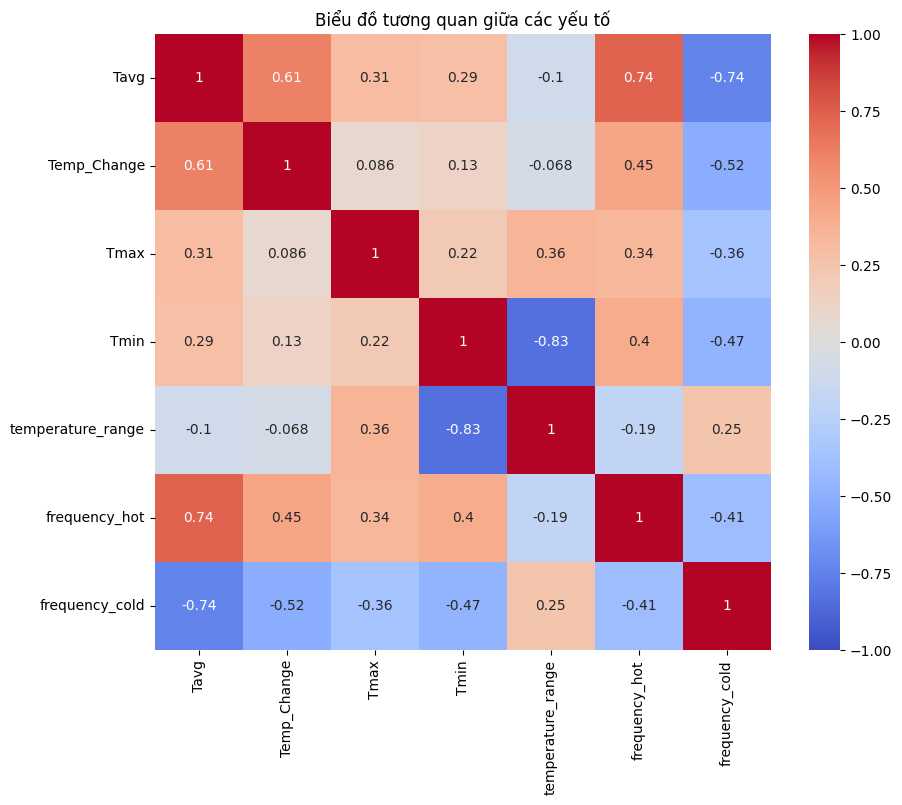

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
df = pd.read_csv('temperature_year.csv')

# Tính toán ma trận tương quan
correlation_matrix = df[['Tavg', 'Temp_Change', 'Tmax', 'Tmin', 'temperature_range', 'frequency_hot', 'frequency_cold']].corr()

# Vẽ biểu đồ tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Biểu đồ tương quan giữa các yếu tố')
plt.show()


In [25]:
import pandas as pd 

df = pd.read_csv('temperature.csv')
